# Leagues Comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import networkx as nx
from collections import Counter

data_partite = pd.read_csv("data_1/data_matches.csv", encoding='latin-1')
campionati = pd.read_csv("data_1/leagues.csv", encoding='latin-1')

In [2]:
def transformation(dataset, column, retain, new_col_names):
    new_data = dataset.merge(campionati, left_on= column, right_on = "Squad", how='outer').fillna(0)
    new_data = new_data[(new_data['League'] != 0) & (new_data[column] != 0)]
    new_data = new_data[retain]
    new_data.columns = new_col_names
    new_data['DR'] = new_data['DR'].apply(lambda x: int(x))
    new_data = new_data.reset_index()
    new_data = new_data.drop(['index'],axis = 1)
    return new_data

df3 = transformation(data_partite, 'Home_Team', ["League","Away_Team","Winner","DR"], ['Home_Team',"Away_Team","Winner","DR"])
df4 = transformation(df3, "Away_Team", ["Home_Team","League","Winner","DR"], ['Home_Team',"Away_Team","Winner","DR"])
df5 = transformation(df4, "Winner", ["Home_Team","Away_Team","League","DR"], ['Home_League',"Away_League","Winner","DR"])

df5 = df5[df5["Home_League"] != df5["Away_League"]]
df5 = df5.reset_index()
df5 = df5.drop(['index'],axis = 1)

In [3]:
listone = [(df5['Home_League'][i], df5['Away_League'][i]) for i in range(len(df5))]
hh = Counter(listone).most_common()

nuova_lista = {}

for i in range(len(hh)):
    if (hh[i][0] not in nuova_lista.keys()) & ((hh[i][0][1], hh[i][0][0]) not in nuova_lista.keys()):
        nuova_lista[hh[i][0]] = hh[i][1]
    elif (hh[i][0] not in nuova_lista.keys()) & ((hh[i][0][1], hh[i][0][0]) in nuova_lista.keys()):
        nuova_lista[(hh[i][0][1], hh[i][0][0])] += hh[i][1]
    elif (hh[i][0] in nuova_lista.keys()) & ((hh[i][0][1], hh[i][0][0]) in nuova_lista.keys()):
        nuova_lista[hh[i][0]] += hh[i][1]

In [4]:
df_a = pd.DataFrame(index = df5.Home_League.unique(),columns = df5.Home_League.unique())
df_a = df_a.fillna(0)

nazioni = df5.Home_League.unique()

for i in range(len(df5)):
    a = Counter(df5.iloc[i][:3].values)
    rev = {v: k for k, v in a.items()}
    loser = rev[1]
    df_a[df5.iloc[i]['Winner']][loser] += df5.iloc[i][3]
    
for i in range(len(list(nuova_lista.keys()))):
    df_a.loc[list(nuova_lista.keys())[i][0],list(nuova_lista.keys())[i][1]] /= nuova_lista[list(nuova_lista.keys())[i]]
    df_a.loc[list(nuova_lista.keys())[i][1],list(nuova_lista.keys())[i][0]] /= nuova_lista[list(nuova_lista.keys())[i]]
    
v = pd.DataFrame(columns = ['vincente',"perdente","di quanto"])
for k in range(len(df_a)):
    for j in range(len(df_a)):
        v = v.append({'vincente': df_a.index[k],'perdente': df_a[df_a.index[k]].index[j],'di quanto':df_a[df_a.index[k]][j]}, ignore_index = True)

v = v[v['vincente'] != v['perdente']]

In [5]:
a = list(set([i for i in v['vincente']]))
b = list(set([i for i in v['perdente']]))
c = list(set(a+b))
subset = v[['perdente', 'vincente','di quanto']]
tuples = [tuple(x) for x in subset.to_numpy()]
tuples = [x for x in tuples if x[2] != 0] 

G = nx.DiGraph()
G.add_nodes_from(c)
G.add_weighted_edges_from(tuples)
G.in_edges(data=True)

InEdgeDataView([('Swiss Super League', 'Eredivisie', {'weight': 0.4}), ('Ligue 1', 'Eredivisie', {'weight': 0.8125}), ('Premier League', 'Eredivisie', {'weight': 0.3888888888888889}), ('Cypro League', 'Eredivisie', {'weight': 4.0}), ('Serie A', 'Eredivisie', {'weight': 0.75}), ('Bundesliga', 'Eredivisie', {'weight': 0.5263157894736842}), ('Denmark League', 'Eredivisie', {'weight': 1.4}), ('HNL 1', 'Eredivisie', {'weight': 1.1818181818181819}), ('Ukraine League', 'Eredivisie', {'weight': 0.6666666666666666}), ('Czech League', 'Eredivisie', {'weight': 0.8}), ('Sweden League', 'Eredivisie', {'weight': 1.5}), ('Turkish League', 'Eredivisie', {'weight': 0.8333333333333334}), ('Belgian League', 'Eredivisie', {'weight': 1.4}), ('Bulgarian League', 'Eredivisie', {'weight': 0.5}), ('Liga Portuguesa', 'Eredivisie', {'weight': 0.5}), ('La Liga', 'Eredivisie', {'weight': 0.4375}), ('Russian League', 'Eredivisie', {'weight': 0.43478260869565216}), ('Hungary League', 'Eredivisie', {'weight': 2.0}), 

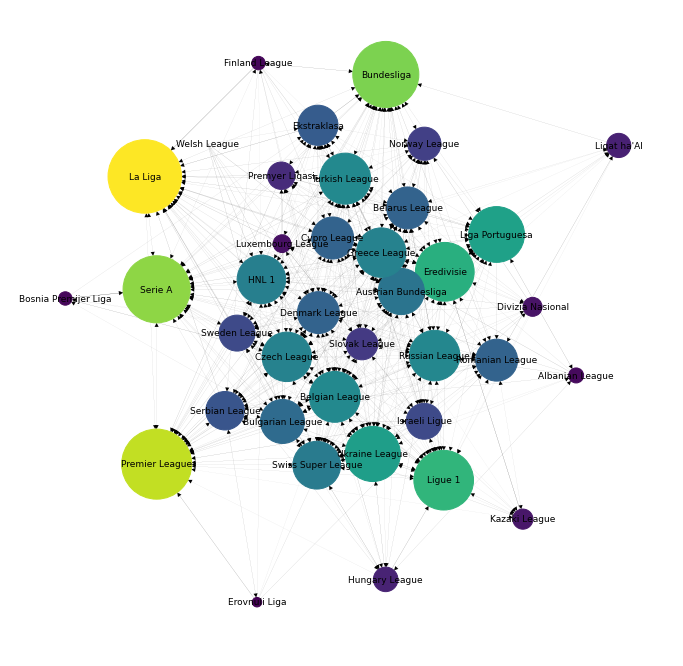

In [8]:
pos = nx.spring_layout(G)

node_size = [90 * G.in_degree(i) * np.mean([k[2]['weight'] for k in list(G.in_edges(i,data = True))]) for i in G]
node_color = [50 * G.in_degree(i) * np.mean([k[2]['weight'] for k in list(G.in_edges(i,data = True))]) for i in G]
weights = [G[i][j]['weight'] * 0.025 for i,j in G.edges()]

plt.figure(figsize = (12,12))
           
nx.draw_networkx(G, 
                 pos,
                 with_labels = False,
                 node_color = node_color,
                 node_size = node_size, 
                 width = weights)

nx.draw_networkx_labels(G, pos = pos, font_color = "black", font_size = 9)

plt.box(on = None)
plt.axis('off')

plt.show()

In [9]:
lista_j = [[i, G.in_degree(i) * np.mean([k[2]['weight'] for k in list(G.in_edges(i,data = True))])] for i in G]
lista_j = [j for j in lista_j if ~np.isnan(j[1])]

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

X = [G.in_degree(i) * np.mean([k[2]['weight'] for k in list(G.in_edges(i,data = True))]) for i in G]
X = [j for j in X if ~np.isnan(j)]
X.append(0)

scaled_x = NormalizeData(X)

y = [[lista_j[i][0], scaled_x[i]] for i in range(len(lista_j))]

diz={}

for i in range(len(y)):
    diz[y[i][0]] = y[i][1]
    
diz = {k: v for k, v in sorted(diz.items(), key=lambda item: item[1], reverse=True)}
diz

{'La Liga': 1.0,
 'Premier League': 0.9082014652471837,
 'Serie A': 0.8332702220226353,
 'Bundesliga': 0.8074177354804625,
 'Ligue 1': 0.6586639885020807,
 'Eredivisie': 0.6385877068139219,
 'Liga Portuguesa': 0.5755124246050453,
 'Ukraine League': 0.5633266392656575,
 'Turkish League': 0.48129247328687463,
 'Belgian League': 0.4783713833566927,
 'Russian League': 0.4725790235210438,
 'Greece League': 0.4521815928407803,
 'Czech League': 0.4521204987593408,
 'HNL 1': 0.4360224213657016,
 'Swiss Super League': 0.422059995790106,
 'Austrian Bundesliga': 0.3942377769624732,
 'Bulgarian League': 0.3583051409388463,
 'Cypro League': 0.32699239811060676,
 'Belarus League': 0.3252724861718854,
 'Romanian League': 0.325008069242103,
 'Denmark League': 0.32463127511716305,
 'Ekstraklasa': 0.2984575585273702,
 'Serbian League': 0.27408918088438233,
 'Sweden League': 0.23913867129525113,
 'Israeli Ligue': 0.237935574264741,
 'Norway League': 0.20319424065590097,
 'Slovak League': 0.18466878376006

In [12]:
second_ranking = pd.read_html('https://www.globalfootballrankings.com/')[0]
second_ranking = second_ranking[['League','Average SPI']]
second_ranking['League'] = second_ranking['League'].apply(lambda x: (' ').join(x.split()[1:]))

lista_SPI = [i for i in second_ranking['Average SPI']]
lista_SPI.append(0)

scaled_SPI = NormalizeData(lista_SPI)

diz2={}

for i in range(len(second_ranking)):
    diz2[second_ranking['League'][i]] = scaled_SPI[i]
    
diz2

{'Barclays Premier League': 1.0,
 'Spanish Primera Division': 0.9562662293289599,
 'German Bundesliga': 0.9464261309279759,
 'Italy Serie A': 0.8779554462211288,
 'French Ligue 1': 0.8301216345496788,
 'Portuguese Liga': 0.7149104824381577,
 'Dutch Eredivisie': 0.7028836955036217,
 'Brasileiro Série A': 0.6740467404674046,
 'Mexican Primera Division Torneo Clausura': 0.6483531501981686,
 'Russian Premier Liga': 0.6251195845291786,
 'English League Championship': 0.6025693590269237,
 'Austrian T-Mobile Bundesliga': 0.5902692360256936,
 'Belgian Jupiler League': 0.5852125187918545,
 'Turkish Turkcell Super Lig': 0.5453054530545305,
 'Swiss Raiffeisen Super League': 0.5416154161541615,
 'Danish SAS-Ligaen': 0.5401120677873446,
 'Major League Soccer': 0.5390187235205685,
 'Argentina Primera Division': 0.5312286456197894,
 'Scottish Premiership': 0.5253519201858685,
 'Japanese J League': 0.4850348503485035,
 'German 2. Bundesliga': 0.48284816181495144,
 'Greek Super League': 0.4679513461801